<a href="https://colab.research.google.com/github/EduardoMoraesRitter/spark/blob/main/Spark_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#NLP
# Nuvem de Palavras
# Remoção de caracteres especiasis
# separar em partes Tokenização
# Remover ruidos os StopWords
# Vetorizar ou Bag of Words
# Modelo de arvore de decisao
# Teste e Metrificação

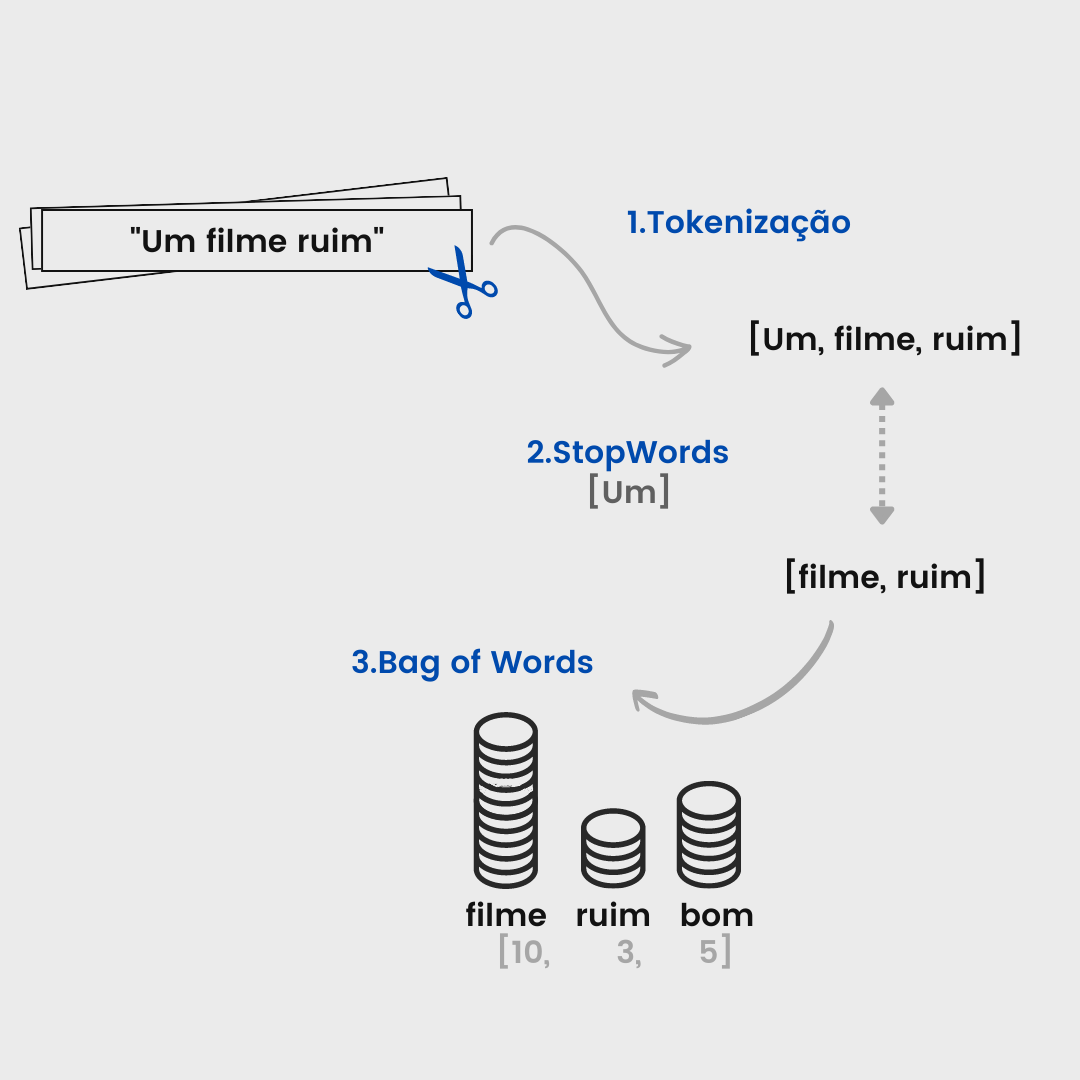

# Configuração

In [2]:
#instalar spark 
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 199 kB 49.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=3ce5c534efc0bc25a13a9a16e487f8b10120cb44351ec633eada76028416eb1a
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [3]:
#Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("nlp") \
    .getOrCreate()

#ler dados do IMDB
https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr

In [4]:
# dados = spark.read.csv("/dados/imdb-reviews-pt-br.csv",
#                        escape="\"",
#                        header=True,
#                        inferSchema=True)


import pandas as pd

url = 'https://github.com/EduardoMoraesRitter/spark/blob/main/dados/imdb-pt-br.xlsx?raw=true'
df = pd.read_excel(url, index_col=0)
print(df.head(5))

dados = spark.createDataFrame(df)
dados.limit(5).show()

                                              text_en  \
id                                                      
1   Once again Mr. Costner has dragged out a movie...   
2   This is an example of why the majority of acti...   
3   First of all I hate those moronic rappers, who...   
4   Not even the Beatles could write songs everyon...   
5   Brass pictures movies is not a fitting word fo...   

                                              text_pt sentiment  
id                                                               
1   Mais uma vez, o Sr. Costner arrumou um filme p...       neg  
2   Este é um exemplo do motivo pelo qual a maiori...       neg  
3   Primeiro de tudo eu odeio esses raps imbecis, ...       neg  
4   Nem mesmo os Beatles puderam escrever músicas ...       neg  
5   Filmes de fotos de latão não é uma palavra apr...       neg  
+--------------------+--------------------+---------+
|             text_en|             text_pt|sentiment|
+--------------------+--------

# Explorar os dados
*   quantidade de linhas e colunas 
*   campos e tipos 
*   conteudos 
*   proporção

In [5]:
#  quantidade de linhas e colunas 
print(dados.count())
len(dados.columns)

21999


3

In [6]:
# campos tipos
dados.printSchema()

root
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [7]:
# conteudo
dados.limit(100).show()

+--------------------+--------------------+---------+
|             text_en|             text_pt|sentiment|
+--------------------+--------------------+---------+
|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|This is an exampl...|Este é um exemplo...|      neg|
|First of all I ha...|Primeiro de tudo ...|      neg|
|Not even the Beat...|Nem mesmo os Beat...|      neg|
|Brass pictures mo...|Filmes de fotos d...|      neg|
|A funny thing hap...|Uma coisa engraça...|      neg|
|This German horro...|Este filme de ter...|      neg|
|Being a long-time...|Sendo um fã de lo...|      neg|
|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
|Wealthy horse ran...|Fazendeiros ricos...|      neg|
|Cage plays a drun...|Cage interpreta u...|      neg|
|First of all, I w...|Primeiro de tudo,...|      neg|
|So tell me - what...|Então me diga - q...|      neg|
|A big disappointm...|Uma grande decepç...|      neg|
|This film is abso...|Este filme é abso...|      neg|
|Heres a decidedly...|Heres 

In [8]:
# proporção
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|12389|
|      pos| 9610|
+---------+-----+



# WordCloud

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
import wordcloud

In [10]:
#amostra com 10%
amostra = dados.select('text_pt').sample(fraction=0.1, seed=101)

textos = [texto['text_pt'] for texto in amostra.collect()]

In [11]:
#collocations palavras separadas
wordcloud = WordCloud(
    width=1000,
    height=600,
    collocations=False, 
    background_color='white', 
    prefer_horizontal=1
).generate(str(textos))

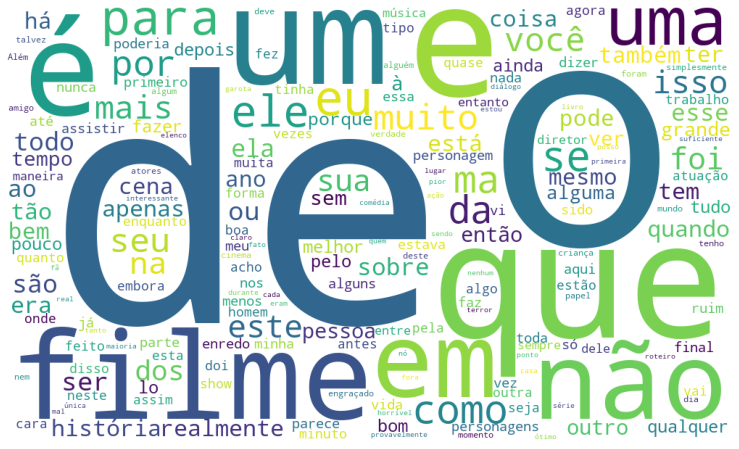

In [12]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Limpeza dos dados

caracters especias
excesso de espaços

In [44]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [45]:
#regex com contra barra \
dados = dados.withColumn("texto_regex", f.regexp_replace("text_pt", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))
dados.show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
#remover os espaços
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))
dados.show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Tokenização 
dividir por palavras, ja colocando em minusculo

https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.RegexTokenizer.html

In [47]:
#exemplo de tokenização com NLTK
import nltk
nltk.download('punkt')

nltk.word_tokenize("mais uma vez o guarda-chuva ta quebrado")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['mais', 'uma', 'vez', 'o', 'guarda-chuva', 'ta', 'quebrado']

In [48]:
from pyspark.ml.feature import Tokenizer

In [49]:
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
tokenizado = tokenizer.transform(dados)

In [50]:
tokenizado.show()

+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+
|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|
+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+
|Once again Mr. Co...|Mais uma vez, o S...|      neg|Mais uma vez o Sr...|Mais uma vez o Sr...|  0.0|[mais, uma, vez, ...|
|This is an exampl...|Este é um exemplo...|      neg|Este é um exemplo...|Este é um exemplo...|  0.0|[este, é, um, exe...|
|First of all I ha...|Primeiro de tudo ...|      neg|Primeiro de tudo ...|Primeiro de tudo ...|  0.0|[primeiro, de, tu...|
|Not even the Beat...|Nem mesmo os Beat...|      neg|Nem mesmo os Beat...|Nem mesmo os Beat...|  0.0|[nem, mesmo, os, ...|
|Brass pictures mo...|Filmes de fotos d...|      neg|Filmes de fotos d...|Filmes de fotos d...|  0.0|[filmes, de, foto...|
|A funny thing h

In [51]:
from pyspark.sql.types import IntegerType

#quantidade de tokens
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

tokenizado.select("texto_limpo", "tokens")\
.withColumn("Freq_tokens", countTokens("tokens")).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Mais uma vez o Sr...|[mais, uma, vez, ...|        168|
|Este é um exemplo...|[este, é, um, exe...|        245|
|Primeiro de tudo ...|[primeiro, de, tu...|        213|
|Nem mesmo os Beat...|[nem, mesmo, os, ...|        324|
|Filmes de fotos d...|[filmes, de, foto...|        244|
|Uma coisa engraça...|[uma, coisa, engr...|        116|
|Este filme de ter...|[este, filme, de,...|        161|
|Sendo um fã de lo...|[sendo, um, fã, d...|        146|
|Tokyo Eyes fala d...|[tokyo, eyes, fal...|        130|
|Fazendeiros ricos...|[fazendeiros, ric...|        167|
|Cage interpreta u...|[cage, interpreta...|        106|
|Primeiro de tudo ...|[primeiro, de, tu...|        315|
|Então me diga  qu...|[então, me, diga,...|        247|
|Uma grande decepç...|[uma, grande, dec...|        107|
|Este filme é abso...|[este, filme, é, ...|     

# Remover StopWords
preposições e pronomes e verbos

## NLTK - StopWord


In [52]:
#nltk e stopwords
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
#stopwords em portugues
from nltk.corpus import stopwords
stop_nltk_pt = stopwords.words("portuguese")

print(len(stop_nltk_pt))
stop_nltk_pt[0:10]

207


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

## pyspark ML - StopWord

In [54]:
from pyspark.ml.feature import StopWordsRemover
stop_ml_pt = StopWordsRemover.loadDefaultStopWords('portuguese')

print(len(stop_ml_pt))
stop_ml_pt[0:10]

203


['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para']

In [55]:
#aplicar a remocao comparando cada um dos metodos
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_nltk_pt)
#remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_ml_pt)
df = remover.transform(tokenizado)
df.show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [56]:
#contagem de quantos foram removidos
df.select("tokens", "texto_final")\
  .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
  .withColumn("Fre_tokens_limpos", countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|Freq_tokens|Fre_tokens_limpos|
+--------------------+--------------------+-----------+-----------------+
|[mais, uma, vez, ...|[vez, sr, costner...|        168|               79|
|[este, é, um, exe...|[exemplo, motivo,...|        245|              138|
|[primeiro, de, tu...|[primeiro, tudo, ...|        213|              117|
|[nem, mesmo, os, ...|[beatles, puderam...|        324|              167|
|[filmes, de, foto...|[filmes, fotos, l...|        244|              144|
|[uma, coisa, engr...|[coisa, engraçada...|        116|               61|
|[este, filme, de,...|[filme, terror, a...|        161|               75|
|[sendo, um, fã, d...|[sendo, fã, longa...|        146|               75|
|[tokyo, eyes, fal...|[tokyo, eyes, fal...|        130|               77|
|[fazendeiros, ric...|[fazendeiros, ric...|        167|               96|
|[cage, interpreta...|[cage, interpret

# Normalização das palavras

colocar a rais da palavra amigos(as) > amig

lematização e stemming ainda nao esta nativo em spark

# BoW - Bag of Words(Vetorizar)
tranformar em um vetor de 0 e 1 cada linha
outros exempos matriz_esparsa, countvectorizer, TF

## CountVector 

conta a frequencia de cada palavra.

`['quatidade', ['index do dicionario'],['frequencia da palavra']]`

In [70]:
#cria o verto
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="texto_final", outputCol="countVec")

In [71]:
#treina o modelo com as palavras, e transforma
model = cv.fit(df)
df_model = model.transform(df)

In [72]:
df_model.show()

+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|            countVec|
+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|Once again Mr. Co...|Mais uma vez, o S...|      neg|Mais uma vez o Sr...|Mais uma vez o Sr...|  0.0|[mais, uma, vez, ...|[vez, sr, costner...|(103706,[0,3,8,16...|
|This is an exampl...|Este é um exemplo...|      neg|Este é um exemplo...|Este é um exemplo...|  0.0|[este, é, um, exe...|[exemplo, motivo,...|(103706,[0,1,2,5,...|
|First of all I ha...|Primeiro de tudo ...|      neg|Primeiro de tudo ...|Primeiro de tudo ...|  0.0|[primeiro, de, tu...|[primeiro, tudo, ...|(103706,[0,4,9,15...|
|Not even 

In [73]:
#quais são as palavras do meu dicionario
model.vocabulary[0:8]

['filme', '', 'filmes', 'sobre', 'tão', 'realmente', 'apenas', 'história']

## Hashing TF
otimiza processamento, limitando em 50 colunas

In [74]:
from pyspark.ml.feature import HashingTF

In [75]:
#numFeatures quantidade de feature
#hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF", numFeatures="50")

#ou
hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HashingTF_177aad7c915f

In [76]:
HTFfeaturizedData = hashingTF.transform(df_model)

HTFfeaturizedData.limit(5).show()

+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|            countVec|           hashingTF|
+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|Once again Mr. Co...|Mais uma vez, o S...|      neg|Mais uma vez o Sr...|Mais uma vez o Sr...|  0.0|[mais, uma, vez, ...|[vez, sr, costner...|(103706,[0,3,8,16...|(50,[1,3,4,5,7,9,...|
|This is an exampl...|Este é um exemplo...|      neg|Este é um exemplo...|Este é um exemplo...|  0.0|[este, é, um, exe...|[exemplo, motivo,...|(103706,[0,1,2,5,...|(50,[0,2,4,5,6,7,...|
|First of all I ha...|Primeiro de tudo ...|      neg|Primeiro de tudo 

## TF-IDF - Term Frequency - Inverse Document Frequency

Frequência do Termo - Inverso da Frequência no Documento que não só contabiliza as palavras, mas também pondera baseado na fórmula abaixo.

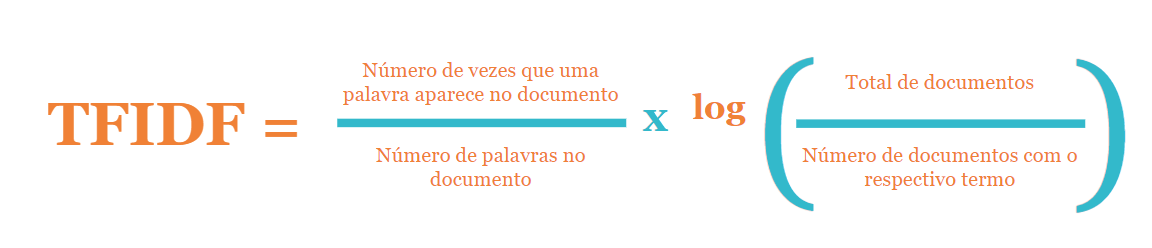

In [77]:
from pyspark.ml.feature import IDF

In [78]:
idf = IDF(inputCol="hashingTF", outputCol="features")

In [79]:
idfModel = idf.fit(HTFfeaturizedData)

TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [80]:
TFIDFfeaturizedData.select("texto_final","features").limit(5).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Variavel Alvo

passar o sentimento para 0 e 1

In [81]:
from pyspark.ml.feature import StringIndexer

In [ ]:
#replace
stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")

#sentiment -> label
dados = stringindexer.fit(dados).transform(dados)

In [84]:
dados.groupBy(["sentiment", "label"]).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      neg|  0.0|12389|
|      pos|  1.0| 9610|
+---------+-----+-----+



# Amostra e Treino

In [ ]:
# separando dados
train, test = dados.randomSplit([0.7, 0.3], seed=101)

train.limit(5).show()

#Modelo de Classidicação

Classificação binaria:
*   regressão logística
*   árvore de decisão(DecisionTreeRegressor)
*   XGBoost(GBTClassifier)

Classifição multiclasses:

*   Regressão logística(LogisticRegression)
*   Floresta aleatória(RandomForestClassifier)

In [85]:
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html
from pyspark.ml.classification import DecisionTreeClassifier

In [86]:
#exemplo

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

df = spark.createDataFrame([ (1.0, Vectors.dense(1.0)), (0.0, Vectors.sparse(1, [], []))], ["label", "features"])
print(df.show())

stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
print(stringIndexer)

+-----+---------+
|label| features|
+-----+---------+
|  1.0|    [1.0]|
|  0.0|(1,[],[])|
+-----+---------+

None
StringIndexer_b4d286cdde14


In [87]:
si_model = stringIndexer.fit(df)
td = si_model.transform(df)
dt = DecisionTreeClassifier(maxDepth=2, labelCol="indexed", leafCol="leafId")
model = dt.fit(td)
model.getLabelCol()

print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b1ff42068c28, depth=1, numNodes=3, numClasses=2, numFeatures=1
  If (feature 0 <= 0.5)
   Predict: 0.0
  Else (feature 0 > 0.5)
   Predict: 1.0



# Pipeline: Transformação

In [88]:
#impost pipe
from pyspark.ml import Pipeline

In [89]:
#separar cada palavra
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")

#remover as palavras sem peso como preposiçoes
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

#contabiliza as palavras sacolas de palavras
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

#ponderando as palavras
tfidf = IDF(inputCol="HTF", outputCol="features")

#escolhendo o modelo
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

In [90]:
#criar pipe
pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dt])

In [91]:
#teste
pipeline.fit(dados).transform(dados).limit(5).show()

+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|Once again Mr. Co...|Mais uma vez, o S...|      neg|Mais uma vez o Sr...|Mais uma vez o Sr...|  0.0|[mais, uma, vez, ...|[mais, uma, vez, ...|(1000,[8,14,16,22...|(1000,[8,14,16,22...|[232.0,105.0]|[0.68842729970326...|       0.0|
|This is an exampl...|Este é um exemplo...|      neg|Este é um exemplo..

# Treinado o modelo e testando

In [92]:
# treinado o modelo e testando
df_model = pipeline.fit(train)

In [93]:
# aplicar teste
predictions = df_model.transform(test)

In [94]:
predictions.show()

+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|"A Texas communit...|"Uma comunidade d...|      neg|Uma comunidade do...|Uma comunidade do...|  0.0|[uma, comunidade,...|[uma, comunidade,...|(1000,[16,29,30,5...|(1000,[16,29,30,5...|[705.0,156.0]|[0.81881533101045...|       0.0|
|"A bored televisi...|"Um diretor de te...|      neg|Um diretor de tel..

# Metricas

https://cursos.alura.com.br/extra/alura-mais/metricas-de-avaliacao-para-classificacao-c1440

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.MulticlassMetrics.html

In [95]:
predictions.select("label", "prediction").limit(5).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+



In [96]:
#acuracia
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [97]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', 
                                              predictionCol='prediction', 
                                              metricName='accuracy')

acuracia = evaluator.evaluate(predictions)
acuracia

0.6385991058122206

In [98]:
#matrix - https://spark.apache.org/docs/2.0.0/api/python/pyspark.mllib.html

from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
predictionAndLabels = predictions.select("label","prediction").rdd
predictionAndLabels.collect()

In [100]:
metrics = MulticlassMetrics(predictionAndLabels)
df_cm = metrics.confusionMatrix().toArray()
df_cm

#metrics.falsePositiveRate(0.0)
#metrics.precision(1.0)
#metrics.recall(2.0)
#metrics.fMeasure(0.0, 2.0)
#metrics.accuracy
#metrics.weightedFalsePositiveRate
#metrics.weightedPrecision
#metrics.weightedRecall
#metrics.weightedFMeasure()
#metrics.weightedFMeasure(2.0)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


array([[2545., 1250.],
       [1175., 1740.]])

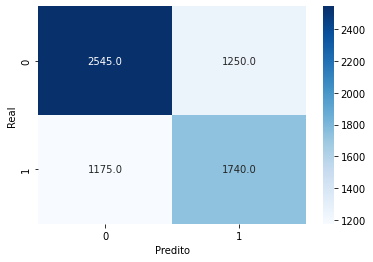

In [126]:
import seaborn as sn

#.1e = scientific notation with 1 decimal point (standard form)
#.2f = 2 decimal places
#.3g = 3 significant figures
#.4% = percentage with 4 decimal places
#.5  = Numero completo
s = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.5')
s.set(xlabel='Predito', ylabel='Real')
plt.show()

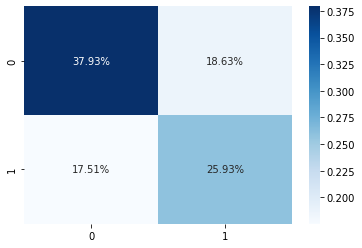

In [107]:
sn.heatmap(df_cm/df_cm.sum(), annot=True, fmt='.2%', cmap='Blues')
plt.show()

# predisendo

In [154]:
frases = spark.createDataFrame([
    (123, "nao gostei do filme, muito ruim"),
    (456, "adorei o filme, mmuito legal")
], ["id", "texto_limpo"])

frases

DataFrame[id: bigint, texto_limpo: string]

In [155]:
teste_classes = df_model.transform(frases)
teste_classes.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|123|nao gostei do fil...|[nao, gostei, do,...|[nao, gostei, fil...|(1000,[199,538,72...|(1000,[199,538,72...|[705.0,156.0]|[0.81881533101045...|       0.0|
|456|adorei o filme, m...|[adorei, o, filme...|[adorei, o, filme...|(1000,[471,538,53...|(1000,[471,538,53...|[505.0,757.0]|[0.40015847860538...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+

